# AUTOENFOQUE DE CÁMARA

#### Santiago Andrés Barragan Paez, Carolina Gomez Ruiz, Alison Gissell Ruiz Ruiz      

#### RESUMEN

En la presente práctica de laboratorio se realiza el enfoque de la cámara del computador de forma automática en un programa que presenta variación aleatoria del foco, el programa se encarga de ajustarlo.

#### INTRODUCCIÓN

A partir del procesamiento de imagenes, por medio de la transformada de Fourier se logra obtener el comportamiento de una imágen en frecuencias, gracias a esto, se puede determinar si una imágen se encuentra borrosa y de esta manera intentar ajustar el foco de una cámara de manera automática.

#### PROCEDIMIENTO Y RESULTADOS

Inicialmente se define la clase Camera en la cual vamos a tener el metodo de obtener un frame al que le calculamos que tan borrosa se encuentra la imagen en dicho frame.

In [1]:
import numpy as np
import cv2

class Camera:
    def __init__(self, camera_file):
        self.ok = False
        self.cap = cv2.VideoCapture(camera_file)
        #self.cap.set(CV_CAP_PROP_SETTINGS, 1);
        self.cap.set(3, 640)  # set the resolution
        self.cap.set(4, 480)
        self.cap.set(cv2.CAP_PROP_AUTOFOCUS, 0) #turn the autofocus off
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        if self.fps <= 0:
            print("ERROR: File or device not found")
            return
        self.counter = 0
        self.focusTime = 5
        self.correctFocus = 0.5
        self.ok = True

    def __del__(self):
        self.cap.release()

    def get_frame(self, focus):
        if self.ok:
            ret, frame0 = self.cap.read()
            #frame = cv2.resize(frame0,(640,480))
            frame = frame0
            if self.counter%(self.fps*self.focusTime) == 0:
                self.correctFocus = np.random.randint(11)/10.0
            self.counter += 1
            error = abs(focus-self.correctFocus)
            blurOrder = int(error*29.0+1)
            blur = cv2.blur(frame,(blurOrder,blurOrder))
            return blur
        else:
            return None

Para el analisis definimos una funcion que nos va a retornar el espectro de magnitud.
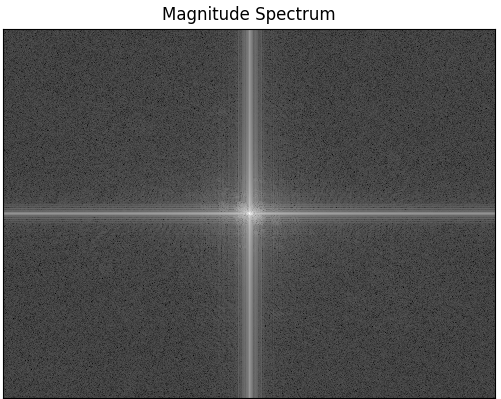

In [2]:
def spectro(array):
    f = np.fft.fft2(array)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(1 + np.abs(fshift))
    return magnitude_spectrum

Se define una funcion la cual nos va a calcular la sumatoria de todo lo que esta entre dos puntos(estos puntos estan en un sector del espectro); hay que tener en cuenta que ademas de esto se tiene que agregar una región cerca de los ejes centrales del esectro pues es la región DC; esto se hace calculando el cuadrado y las dos areas correspondientes del espectro.
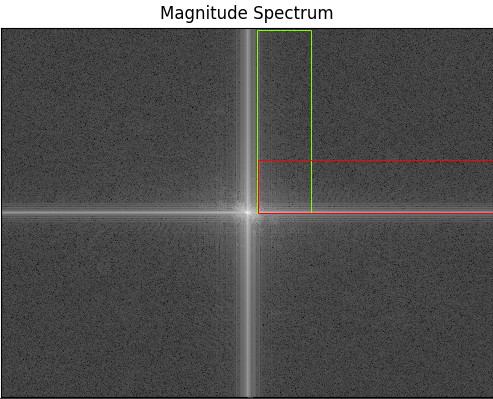

In [3]:
def sum(inicio_x,inicio_y,final_x,final_y,width,height,array):
    sumatoria_cuadrado = 0
    #sumatoria del cuadrado de espectro
    for x in range(inicio_y,final_y):
        for y in range(inicio_x, final_x):
            sumatoria_cuadrado = sumatoria_cuadrado + array[x, y]

    sumatoria = 0
    #sumatoria del sector de x
    for x in range(inicio_y,final_y):
        for y in range(inicio_x, width):
            sumatoria = sumatoria+ array[x, y]
    #sumatoria del sector de y
    for x in range(inicio_y,height):
        for y in range(inicio_x, final_x):
            sumatoria = sumatoria+ array[x, y]
    return sumatoria-sumatoria_cuadrado

Se procede a realizar la función principal la cual va a recibir un arreglo al que se saca del espectro; se calculan 4 puntos importantes que corresponden al punto central del espectro recortandolo en solo 1 cuadrante y el punto máximo para ese cuadrante con el fin de hallar un indice en x que indique que el area parcial ya superó el area total del cuadrante, pues entre mas cercano sea el numero a 0 la imagen es mas borrosa.

También se calcula una pendiente m entre el centro y el extremo del cuadrante para que cada vez el área parcial que se va incrementando aumente de una forma regular tanto en x como en y, como se puede observar en el siguiente gráfico.

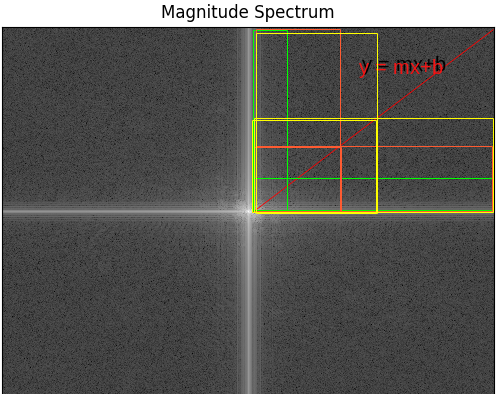

In [4]:
def borroso(img,size=1):
    array = spectro(img)
    height = np.size(array, 0)
    width = np.size(array, 1)
    #plt.plot(array[int(height / 2), int(width/2):])
    #plt.show()

    x_inicial = int(width / 2)
    x_final = int(width)
    y_inicial = int(height / 2)
    y_final = int(height)
    acumulado_total = sum(x_inicial,y_inicial,x_final,y_final,width,height,array)
    m = (y_final-y_inicial)/(x_final-x_inicial)

    #indice prueba1
    indices = []
    for x in range(x_inicial,x_final,size):
        y = int(m*x)
        acumulado_linea = sum(x_inicial,y_inicial,x,y,width,height,array)
        if acumulado_linea > (acumulado_total/2):
            indices = x
            break
    return indices

Ahora simplemente se tiene que capturar un frame de la camara y hallarle el indice que va a variar a medida que cambiemos el foco, el programa varía el foco hasta que el índice baje y se modifica el foco alrededor de este valor.

In [5]:
indice =0
cam = Camera(camera_file=0)
cv2.namedWindow('Camera')

mejor = 10000
dirreccion = 1
ultimo = 0
focus = 0

while(True):
    frame = cam.get_frame(focus=focus)
    frame_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    foco = borroso(frame_g)

    if foco < mejor:
        mejor = foco

    if foco > ultimo:
        if mejor < foco:
            dirreccion *= -1

    ultimo = foco
    focus = focus + (0.05 * dirreccion)
    if (focus < -2) | (focus > 2):
        mejor = 10000
        focus = 0

    cv2.putText(frame,"foco = %.2f" % focus + " mejor=" + str(mejor) + " indice=" + str(foco),(5,20),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,200),1,cv2.LINE_AA)
    cv2.imshow('Camera', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

#### CONCLUSIONES

* La transformada de Fourier es fundamental a la hora de determinar si una imagen es borrosa debido a que el comportamiento frecuencial de la imagen se ve modificado, eliminando las frecuencias altas que se observan en los bordes del espectro de magnitud.

* Existe otra forma de saber si una imágen es más borrosa que otra y es a través de realizar convolución a la imágen con un kernel laplaciano que identifica la varianza que existe entre los pixeles, ya que si una imágen es borrosa la varianza existente es más baja.

* El algoritmo de la suma del arreglo es lento porque se realizan demasiadas sumas de posiciones de arreglos en dos ciclos for, sin embargo, el algoritmo se puede realizar con el uso de la herramienta "integral" que ofrece opencv, disminuyendo de esta manera la lentitud del video.

#### REFERENCIA

https://stackoverflow.com/questions/7765810/is-there-a-way-to-detect-if-an-image-is-blurry